# Learning Specification from User Demonstration on Seshia Paper's Env

**FOR SESHIA's paper on Learning Task Specifications from Demonstrations:**

In this notebook, we're going to explore learning a known specification from demonstrations of the known specification on the product of the specification and a transition system model for a simple environment.

We will then apply the learned specification to an environment with a different robot / environmental dynamics, but with the same intended goal as in the environment where we demonstrated the task.

This shows that we can actually learn the intended task the user had in mind when they demonstrate it on a system with actual dynamics, and then apply that specification to a different environment.

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display
from sklearn.model_selection import train_test_split
import itertools

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface
from wombats.automaton import Automaton
from wombats.utils import get_experiment_paths

# setting all paths
EXPERIMENT_NAME = 'seshia_paper_reproduction'
ENV_ID_1 = 'MiniGrid-LavaComparison_seshia-v0'
ENV_ID_2 = 'MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0'
ENV_ID_3 = 'MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Wide-v0'
ENV_ID_4 = 'MiniGrid-AlternateLavaComparison_OnlyWaterPath_Wide-v0'
ENV_ID_5 = 'MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Narrow-v0'
ENV_ID_6 = 'MiniGrid-AlternateLavaComparison_OnlyWaterPath_Narrow-v0'

new_env_IDs = [ENV_ID_3, ENV_ID_4]

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
GYM_MONITOR_LOG_DIR = path_data['GYM_MONITOR_LOG_DIR']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

## Loading in the Desired LTL-style PDFA Specification

We're going to assume the user has some task in mind that can be expressed as some form of complicated LTL formula that has been translated to a DFA with probabilistic weights to encode their task preferences.

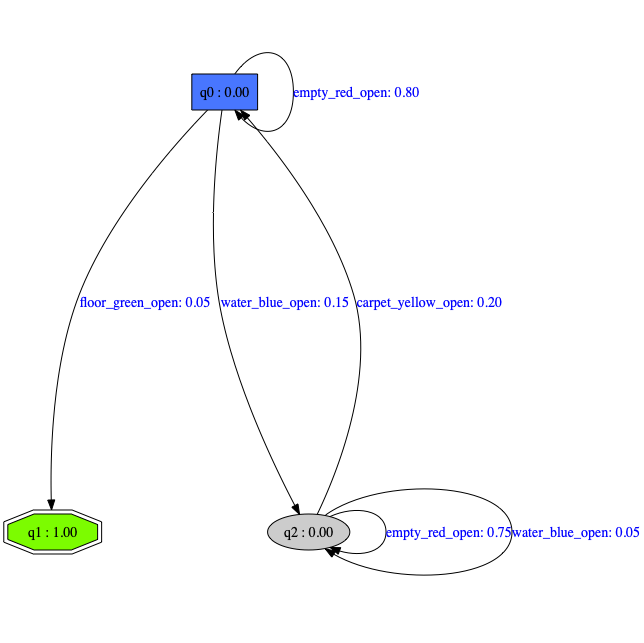

In [3]:
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)

pdfa_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID_1, 'PDFA']))

## Loading in the Simplified Transition System for Demonstration

We are going to demonstrate this specification using a simplified robot that can only go in each cardinal direction

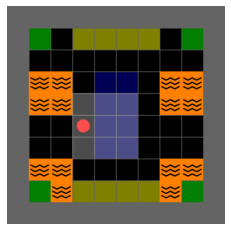

/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


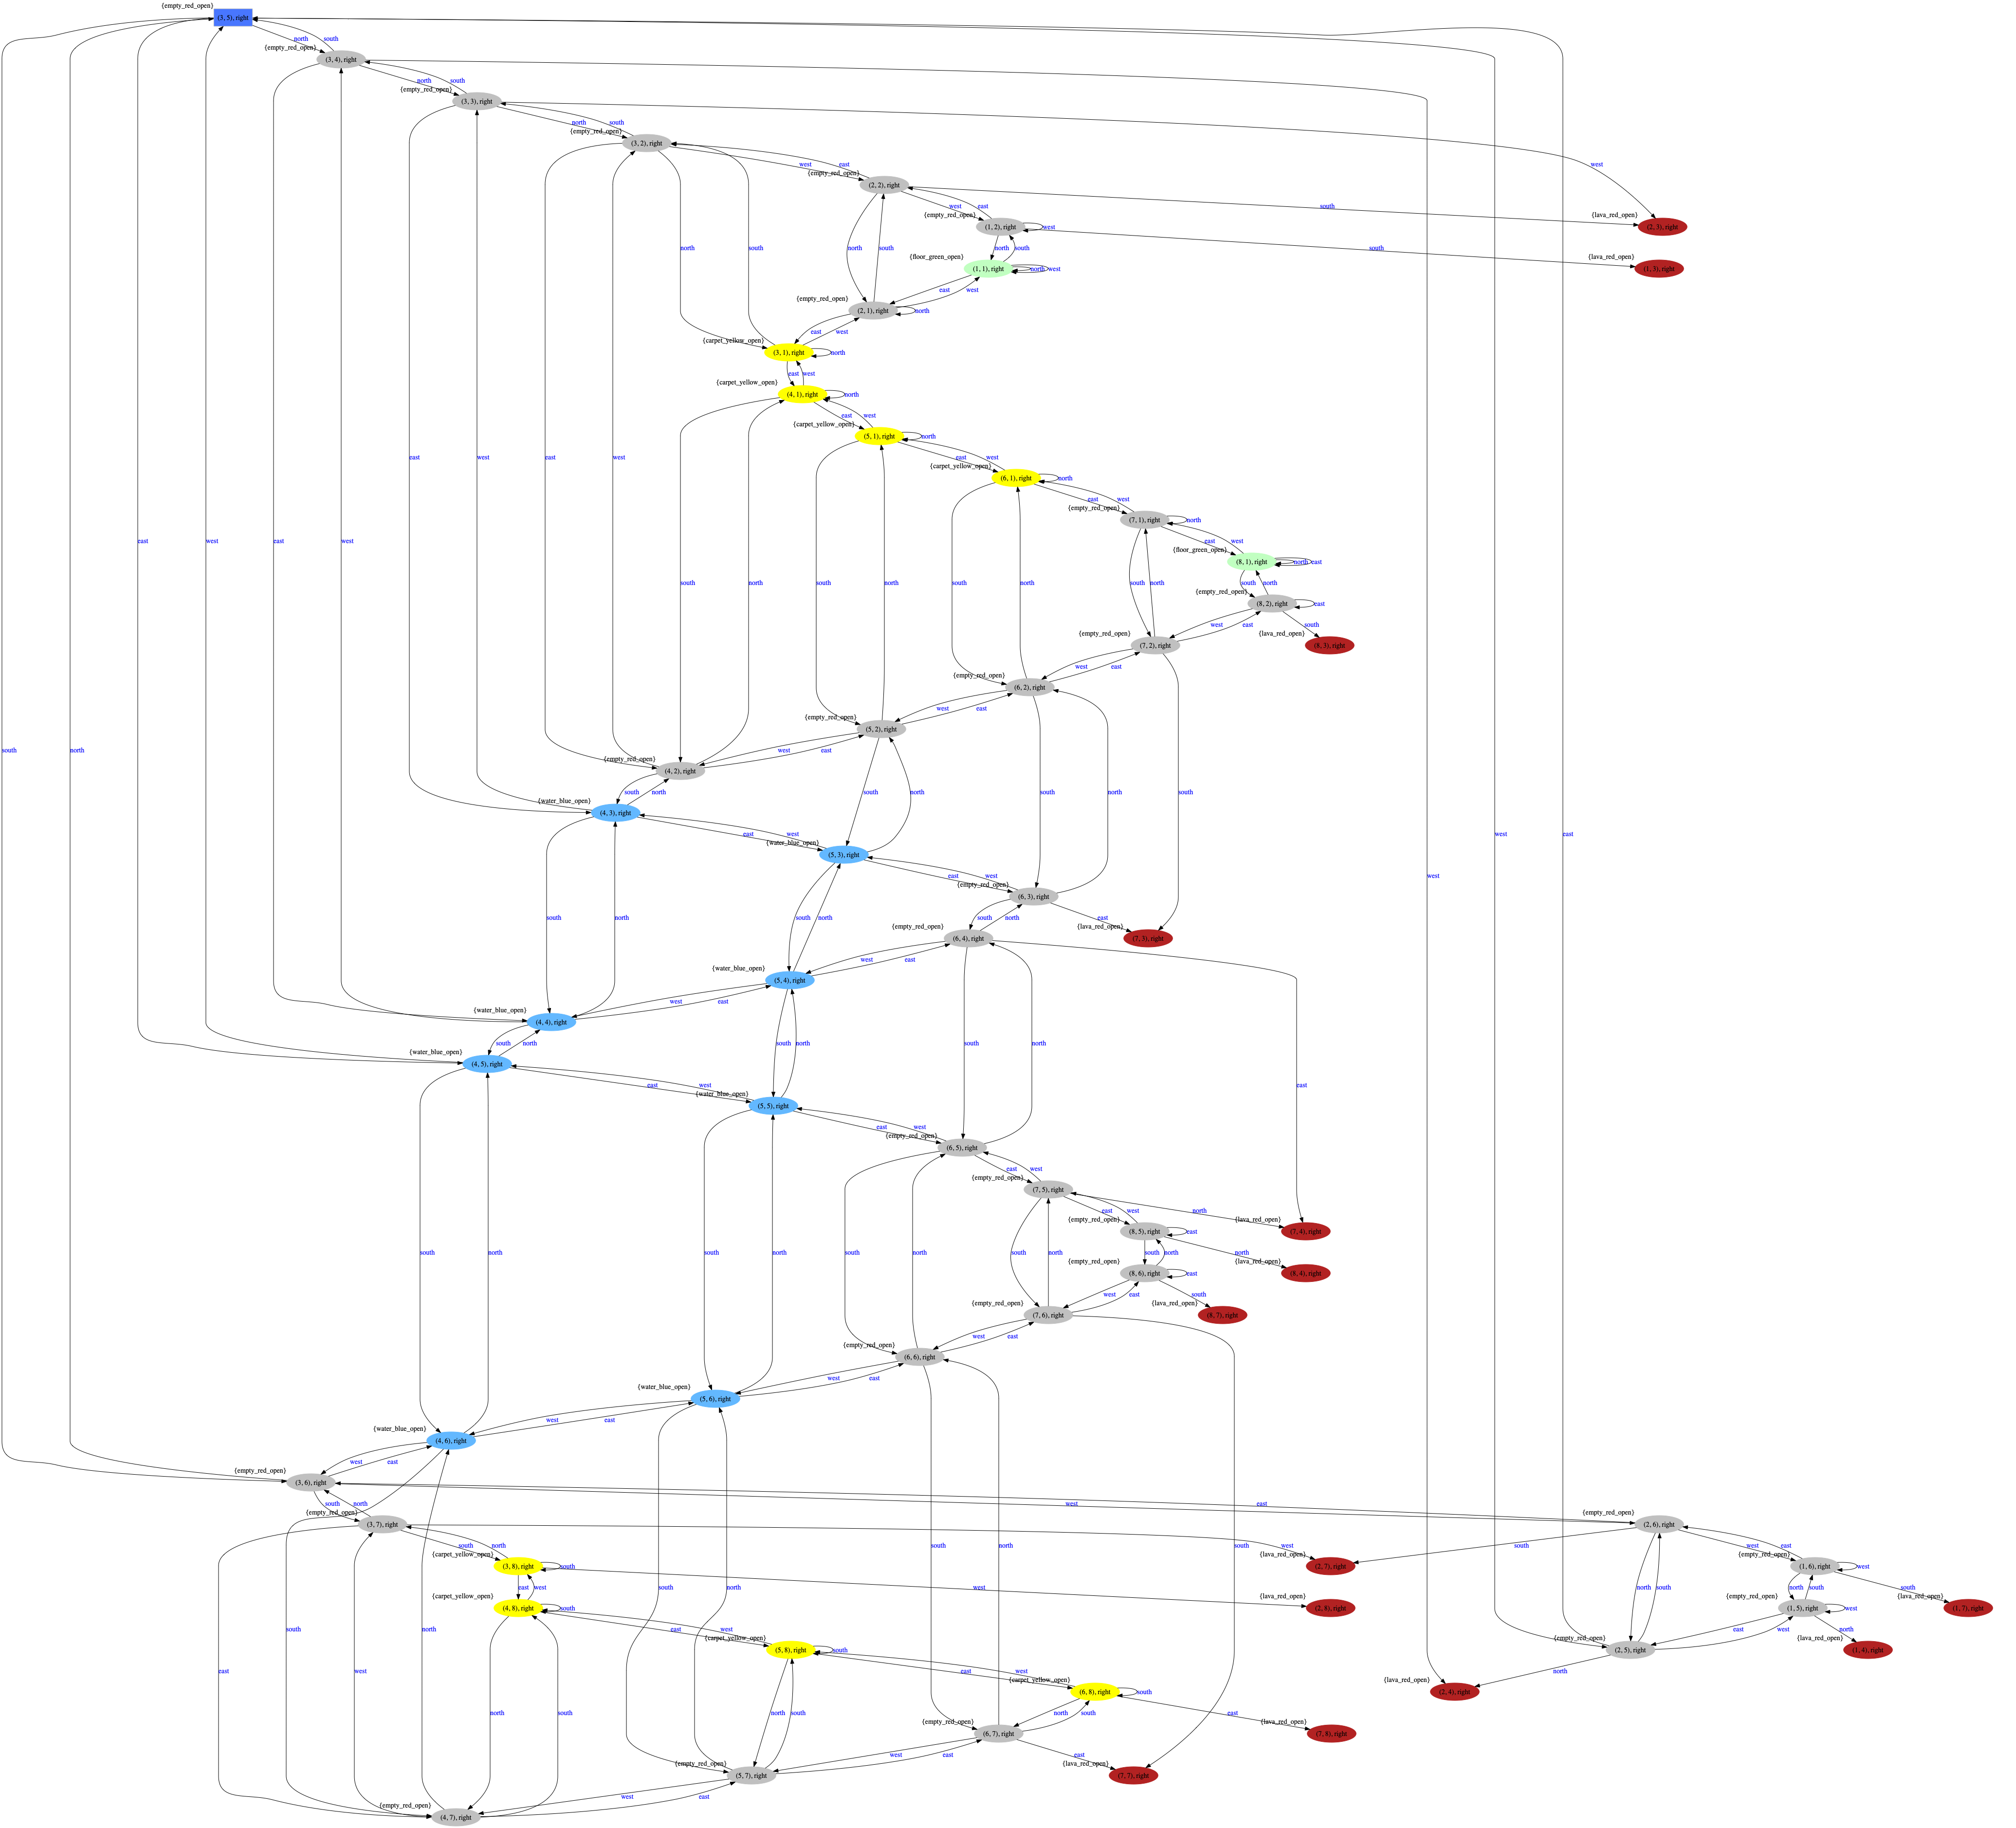

In [4]:
env = gym.make(ENV_ID_1)

env = StaticMinigridTSWrapper(env, actions_type='simple_static',
                              monitor_log_location=GYM_MONITOR_LOG_DIR)
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
minigrid_TS.draw('_'.join([EXPERIMENT_NAME, ENV_ID_1, 'TS']))

In [5]:
minigrid_TS.observations

{'carpet_yellow_open',
 'empty_red_open',
 'floor_green_open',
 'lava_red_open',
 'water_blue_open'}

In [6]:
list(minigrid_TS.actions)

[<SimpleStaticActions.north: 0>,
 <SimpleStaticActions.south: 1>,
 <SimpleStaticActions.east: 2>,
 <SimpleStaticActions.west: 3>]

## Generating Correct System Demonstrations

Here, we are now going to sample behavioral demonstrations of the robot in its environment that adhere to the given specification.

### Giving the Demonstrations to the System

Here, we give the learner the EXACT same symbols as they would have gotten in the paper's 5 demonstrations. This is akin to demonstrating all of the most characteristic paths in the PDFA specification on the product's dynamics.

In [7]:
def eval_sampled_traces(traces, record_video=True):
    if traces is None:
        return
    
    output_strings = []
    for controls, length, prob in zip(*traces):
        if controls is None:
            continue
        output_string, _, video_path = minigrid_TS.run(
            controls,
            record_video=record_video,
            overwrite_old_video=record_video)
        output_strings.append(output_string)
        
        if record_video:
            print(pdfa_specification.cross_entropy_approx(output_string))
            print(prob)
            print(length)
        
        if record_video:
            v = Video(video_path, embed=True,
                      html_attributes="controls muted autoplay loop")
            display(v)
        
    return output_strings

In [8]:
a = minigrid_TS.actions
paper_controls = []
paper_controls.append([a.north, a.north, a.north, a.west, a.north, a.west])
paper_controls.append([a.north, a.north, a.north, a.north, a.west, a.west])
paper_controls.append([a.north, a.north, a.east, a.west, a.north, a.north, a.west, a.west])
paper_controls.append([a.north, a.east, a.north, a.north, a.north, a.west, a.west, a.west])
paper_controls.append([a.east, a.east, a.north, a.north, a.north, a.north, a.east, a.east, a.east])

paper_samples = [(controls, len(controls), None) for controls in paper_controls]

paper_samples = eval_sampled_traces(zip(*paper_samples), record_video=True)

0.8933566663159336
None
6


inf
None
6


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q0) transition distribution
  warnings.warn(str(e))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


1.277623240227563
None
8


inf
None
8


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q0) transition distribution
  warnings.warn(str(e))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


inf
None
9


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:194: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q0) transition distribution
  warnings.warn(str(e))
/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


## Learning the Specification

Now that we have generated traces, we can create training / test data for learning with `flexfringe` and then for evaluating in `wombats`.

### Creating Training / Test Datasets

We need to learn a specification over state observations, not over control signals, so we use the ouput words from runs of the sampled controls on the original TS as the sampled traces to feed the learning algorithm:

In [9]:
traces = paper_samples

train_data_file = pdfa_specification.write_traces_to_file(
    traces,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)

### Learning with `Flexfringe`

In [10]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)
flexfringe.infer_model(get_help=True)

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=1 -x=0 -w=0 -b=1 -f=0 -I=0 -t=1 -l=0 -q=0 -y=0 -p=0.6 --output-dir=experiments/seshia_paper_reproduction/flexfringe_data/dfa /Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/experiments/seshia_paper_reproduction/flexfringe_data/seshia_paper_reproduction_train 
sat_program : 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  x6  m99960  x6  m99980  x6  m99986  m99956  x8  x4  x1  

found inte

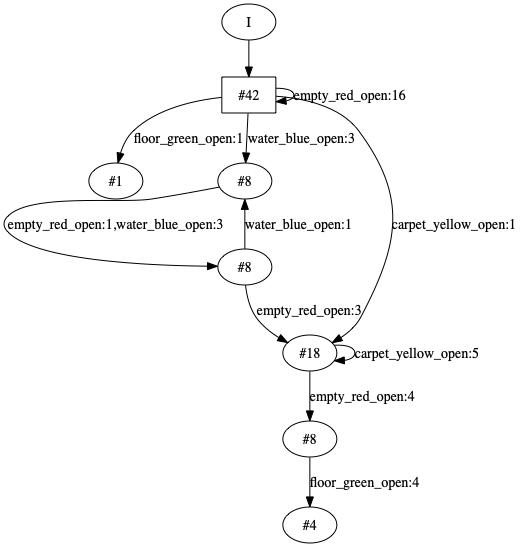

In [11]:
flexfringe.infer_model(training_file=train_data_file,
                       h='kldistance',
                       d='kl_data',
                       n='1',
                       x='0',
                       w='0',
                       b='1',
                       f='0',
                       I='0',
                       t='1',
                       l='0',
                       q='0',
                       y='0',
                       p='0.6')

# flexfringe.draw_initial_model()
flexfringe.draw_learned_model()

loading into `wombats`:

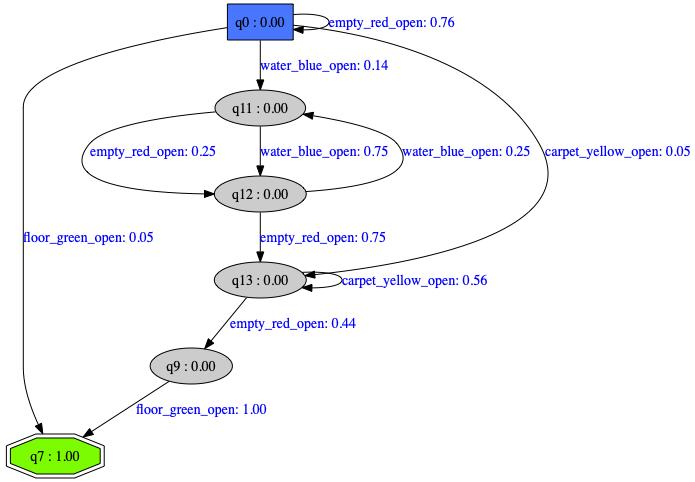

In [12]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   merge_sinks=True)

learned_pdfa.draw('_'.join([EXPERIMENT_NAME, ENV_ID_1, 'learned', 'PDFA']))

## Computing the Most-Probable, Possible Controller

We see here that we get good results from this learning process. The learned specification has some limitations, for example in state `q9` it has no self-transition that would allow a robot in a different environment to make a jump of more than one cell from a carpet cell to a goal cell. This is not really a negative thing, as it is just as possible that we intended to inform the robot to only ever jump from a carpet cell to a goal cell if they're one cell apart.

using env: MiniGrid-LavaComparison_seshia-v0
using actions: simple_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


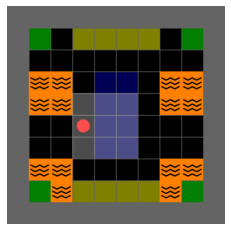

underlying transition system


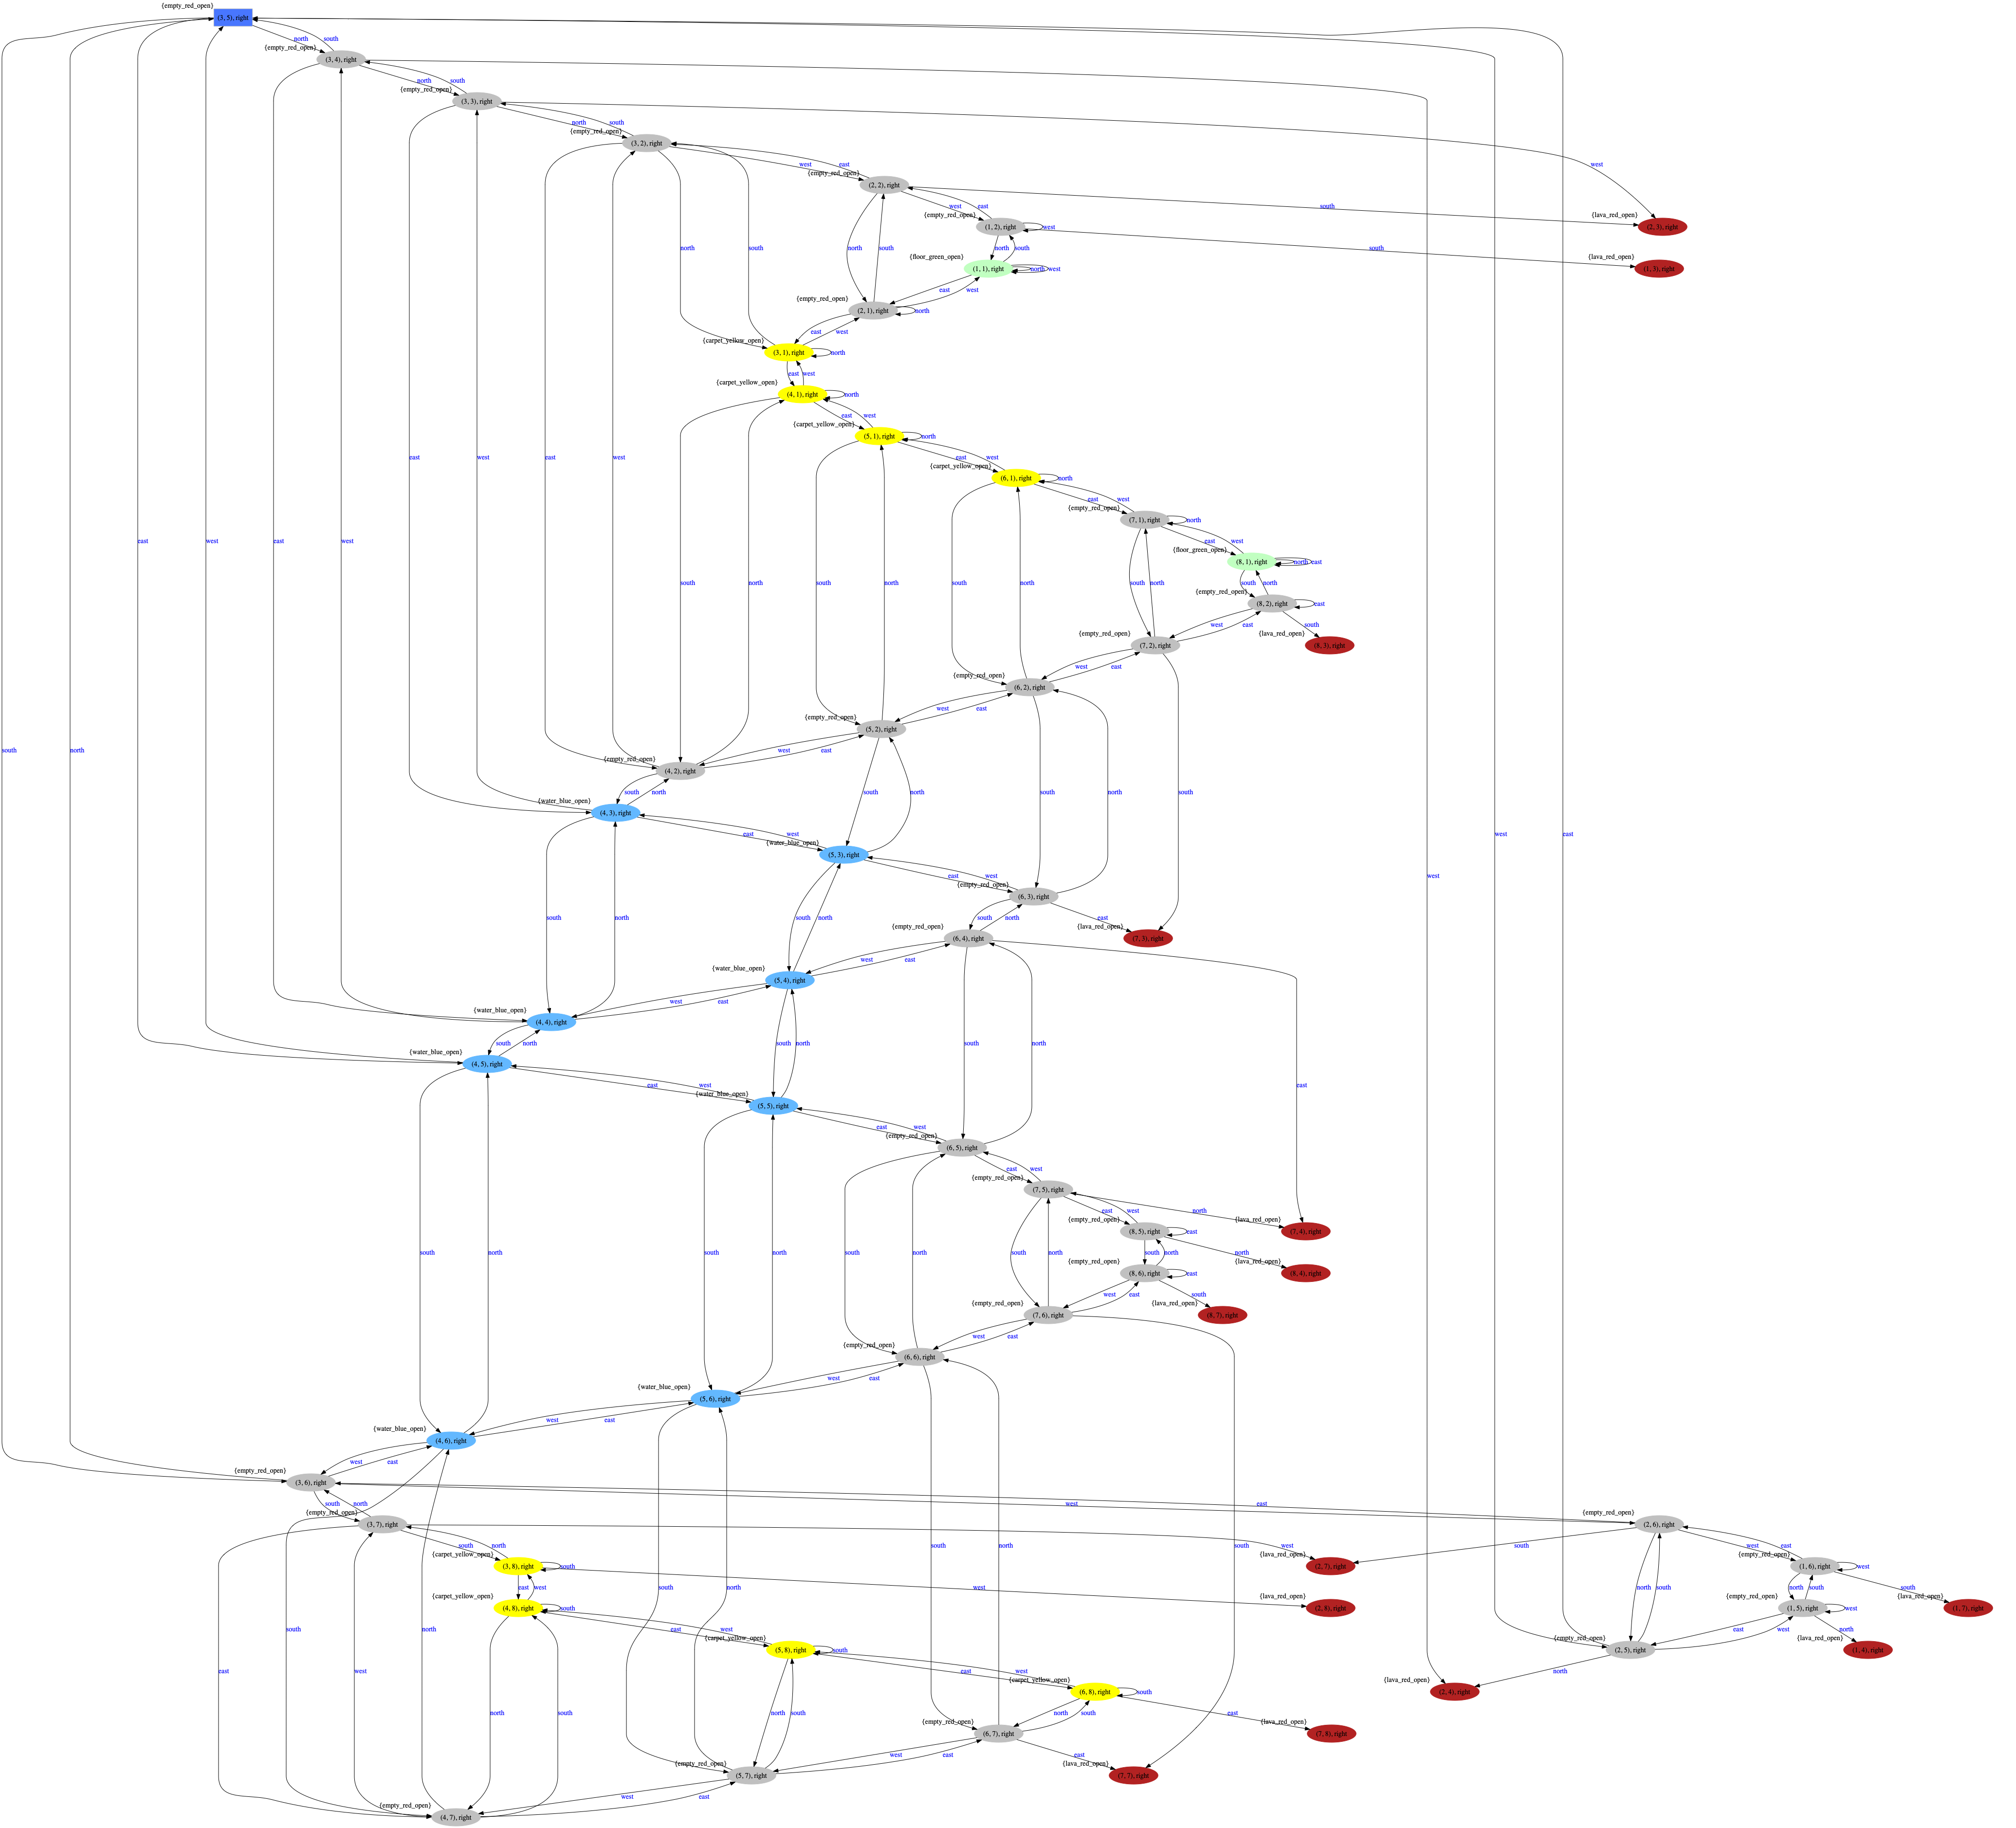

product automaton


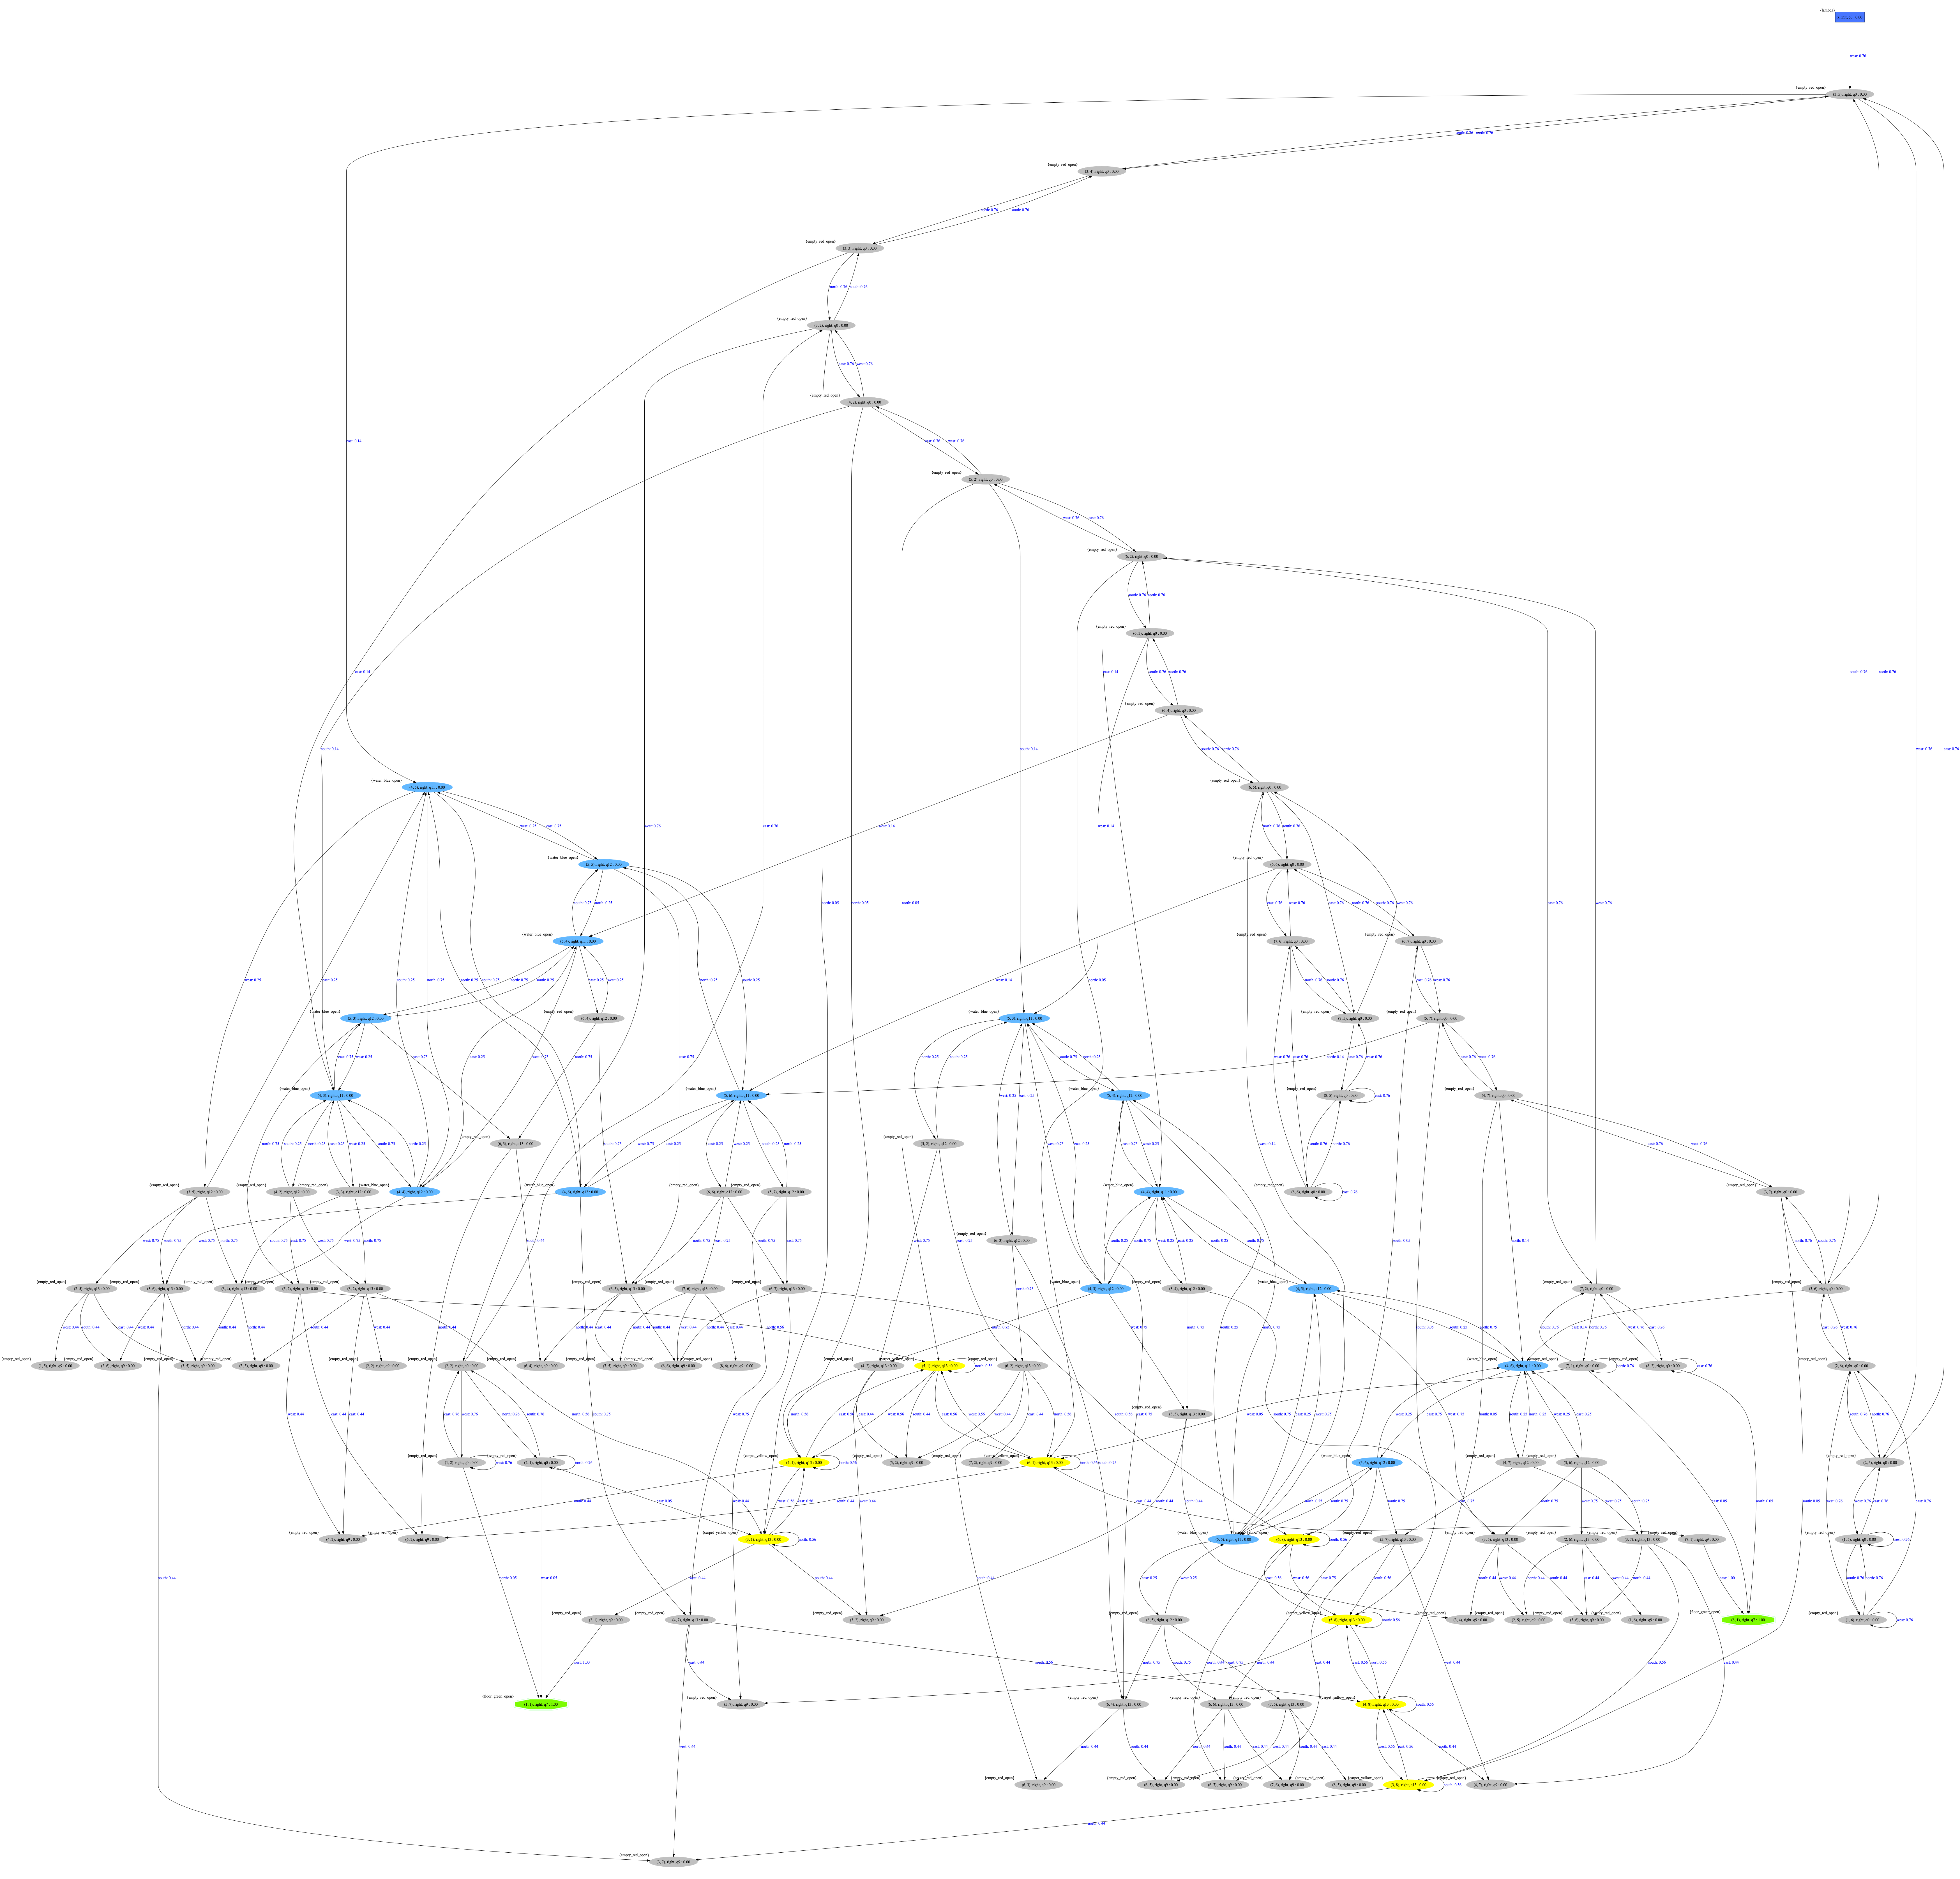


Optimal Controls: ['north', 'north', 'north', 'west', 'north', 'west']
Probability of Generated TS Observations in Spec: 0.009315042330281527
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(3, 4), right', '(3, 3), right', '(3, 2), right', '(2, 2), right', '(2, 1), right', '(1, 1), right']


In [13]:
def solve_environment(specification, ENV_ID, actions_type='simple_static',
                      show_figures=False, record_video=True):
    
    print('using env:', ENV_ID)
    print('using actions:', actions_type)

    env = gym.make(ENV_ID)
    env = StaticMinigridTSWrapper(env, actions_type=actions_type,
                                  monitor_log_location=GYM_MONITOR_LOG_DIR)
    env.reset()
    
    TS = active_automata.get(automaton_type='TS', graph_data=env,
                             graph_data_format='minigrid')

    if show_figures:
        env.render_notebook()
        print('underlying transition system')
        TS.draw('_'.join([EXPERIMENT_NAME, ENV_ID_1, 'TS']))

    product = active_automata.get(automaton_type='Product',
                                  graph_data=(TS, specification))
    if show_figures:
        print('product automaton')
        product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'product']))

    (controls,
     prob_of_controls_under_spec) = product.compute_strategy()

    print(f'Optimal Controls: {controls}')
    print(f'Probability of Generated TS Observations in Spec: ' +
          f'{prob_of_controls_under_spec}')

    (output_string,
     visited_states,
     video_path) = TS.run(controls, record_video=record_video)
    
    print(output_string)
    print(visited_states)
    if record_video:
        v = Video(video_path, embed=True,
                  html_attributes="controls muted autoplay loop")
        display(v)
        
solve_environment(learned_pdfa, ENV_ID_1, show_figures=True)

## Trying out the Specification with Different Environments / Robots

Here, we want to show that the specification we learned has a lot of generalization power, and captures the appropriate task for a large variety of different robots .

The learning environment, but with lava added to block the routes between the lava and the water, forcing the robot to go through the water if it wishes to complete the task.

In [14]:
solve_environment(learned_pdfa, ENV_ID_2)

using env: MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0
using actions: simple_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['south', 'east', 'east', 'south', 'south', 'east', 'east', 'east']
Probability of Generated TS Observations in Spec: 0.0063987970261590804
['empty_red_open', 'empty_red_open', 'water_blue_open', 'water_blue_open', 'empty_red_open', 'carpet_yellow_open', 'carpet_yellow_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(3, 6), right', '(4, 6), right', '(5, 6), right', '(5, 7), right', '(5, 8), right', '(6, 8), right', '(7, 8), right', '(8, 8), right']


Now, what if have a completely different robot try to accomplish the same task in the same two environments? We should compute a *different* sequence of actions for it to make that match the same task specification.

In [15]:
solve_environment(learned_pdfa, ENV_ID_1, actions_type='static')
solve_environment(learned_pdfa, ENV_ID_2, actions_type='static')
solve_environment(learned_pdfa, ENV_ID_1, actions_type='diag_static')
solve_environment(learned_pdfa, ENV_ID_2, actions_type='diag_static')

using env: MiniGrid-LavaComparison_seshia-v0
using actions: static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['left', 'forward', 'forward', 'forward', 'left', 'forward', 'forward', 'right', 'forward']
Probability of Generated TS Observations in Spec: 0.004119902103966432
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(3, 5), up', '(3, 4), up', '(3, 3), up', '(3, 2), up', '(3, 2), left', '(2, 2), left', '(1, 2), left', '(1, 2), up', '(1, 1), up']


using env: MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0
using actions: static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['forward', 'forward', 'right', 'forward', 'forward', 'forward', 'left', 'forward', 'forward', 'forward']
Probability of Generated TS Observations in Spec: 0.0008748355309201867
['empty_red_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'empty_red_open', 'carpet_yellow_open', 'carpet_yellow_open', 'carpet_yellow_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(4, 5), right', '(5, 5), right', '(5, 5), down', '(5, 6), down', '(5, 7), down', '(5, 8), down', '(5, 8), right', '(6, 8), right', '(7, 8), right', '(8, 8), right']


using env: MiniGrid-LavaComparison_seshia-v0
using actions: diag_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['northeast', 'northeast', 'northwest', 'northwest', 'southwest', 'northwest']
Probability of Generated TS Observations in Spec: 0.015117157974300828
['empty_red_open', 'water_blue_open', 'water_blue_open', 'empty_red_open', 'carpet_yellow_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(4, 4), right', '(5, 3), right', '(4, 2), right', '(3, 1), right', '(2, 2), right', '(1, 1), right']


using env: MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0
using actions: diag_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['southeast', 'northeast', 'southeast', 'southeast', 'southeast']
Probability of Generated TS Observations in Spec: 0.02721088435374149
['empty_red_open', 'water_blue_open', 'water_blue_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(4, 6), right', '(5, 5), right', '(6, 6), right', '(7, 7), right', '(8, 8), right']


Now, let's try this specification on a completely different environment, with a completely different goal, with all the different robots:

In [16]:
all_actions_types = ['simple_static', 'static', 'diag_static']

all_experiments = itertools.product(new_env_IDs, all_actions_types)

for env_ID, actions_type in all_experiments:
    solve_environment(learned_pdfa, env_ID, actions_type=actions_type)

using env: MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Wide-v0
using actions: simple_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['east', 'east', 'east', 'north', 'north', 'north', 'north', 'north', 'north', 'north', 'north', 'north', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'south', 'south', 'south', 'south', 'south', 'south', 'south', 'south', 'south']
Probability of Generated TS Observations in Spec: 4.596254780854823e-06
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floo

using env: MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Wide-v0
using actions: static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['forward', 'forward', 'forward', 'left', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'right', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'right', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward']
Probability of Generated TS Observations in Spec: 2.0328538583718125e-06
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'e

using env: MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Wide-v0
using actions: diag_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['northeast', 'northeast', 'northeast', 'northwest', 'northeast', 'northwest', 'northeast', 'northwest', 'northeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'southeast', 'southwest', 'southeast', 'southwest', 'southeast', 'southwest', 'southeast', 'southwest', 'southeast']
Probability of Generated TS Observations in Spec: 1.3639590851370652e-05
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_o

using env: MiniGrid-AlternateLavaComparison_OnlyWaterPath_Wide-v0
using actions: simple_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['east', 'east', 'east', 'north', 'north', 'north', 'north', 'north', 'north', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east', 'south', 'west', 'south', 'west', 'west', 'west', 'west', 'west', 'west', 'south', 'south', 'south', 'east', 'east', 'east', 'east', 'east', 'east', 'south', 'east', 'east', 'east', 'east']
Probability of Generated TS Observations in Spec: 4.630126745572468e-13
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_

using env: MiniGrid-AlternateLavaComparison_OnlyWaterPath_Wide-v0
using actions: static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['forward', 'forward', 'forward', 'left', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'right', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'right', 'forward', 'forward', 'forward', 'forward', 'right', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'left', 'forward', 'forward', 'forward', 'left', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward']
Probability of Generated TS Observations in Spec: 9.44923825627034e-15
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 

using env: MiniGrid-AlternateLavaComparison_OnlyWaterPath_Wide-v0
using actions: diag_static


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['northeast', 'northeast', 'northeast', 'northwest', 'northeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'southeast', 'southwest', 'southwest', 'northwest', 'southwest', 'northwest', 'southwest', 'southwest', 'southeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast', 'northeast', 'southeast']
Probability of Generated TS Observations in Spec: 3.9082972205107594e-11
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_b